## Libraries


In [12]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import warnings

warnings.filterwarnings("ignore")

from os import path, listdir
from torchvision import transforms
from tqdm import tqdm

from torch.utils.data import DataLoader

import pandas as pd
from skimage import transform, filters, img_as_ubyte, color, img_as_float
from skimage.transform import rotate
from skimage.io import imread, imsave, imshow
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from operator import sub
from CatDogDataset import CatDogDataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Configuration


In [2]:
CONFIG = {
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "IMAGE_SIZE": (128, 128),
    "DATA_PATH": path.join(path.abspath(path.pardir), "data", "images"),
    "SEED": 27,
    "MODEL": {"EPOCH": 100, "LEARNING_RATE": 1e-6},
}

random.seed(CONFIG.get("SEED"))

files_to_remove = (
    os.path.join(folder, file)
    for folder, _, files in os.walk(path.join(CONFIG.get("DATA_PATH")))
    for file in files
    if "generated" in file
)

any(map(os.remove, files_to_remove))

False

## Data

### Preparation

The dataset states the following:

_All images with 1st letter as captial are cat images while images with small first letter are dog images._

As this project will be evaluation the race and classification of the animals (breed and species), we'll transform the label dataset into one with increased semantic charge, replacing species to `cat` or `dog` and the breed to its respective name. This will be replaced with a label enconder when trainging the model and the only advantage of it is having some increased ease when exploring the results; leaving [magic numbers](<https://en.wikipedia.org/wiki/Magic_number_(programming)>) out of the paper

Well be using a custom train/validation/test split of 70/15/15. As such, we'll be merging the label files and creating the splits from them


In [3]:
image_files = [
    path.join(CONFIG.get("DATA_PATH"), file)
    for file in listdir(CONFIG.get("DATA_PATH"))
    if file.endswith(".jpg")
]

labels = pd.DataFrame(
    {
        "image_name": image_files,
        "species": [
            "cat" if path.basename(file)[0].isupper() else "dog" for file in image_files
        ],
        "breed": [
            "_".join(path.basename(file).split("_")[:-1]).lower()
            for file in image_files
        ],
    }
)
labels

,image_name,species,breed
0,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
1,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
2,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
3,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
4,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
...,...,...,...
7385,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7386,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7387,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7388,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier


### Analysis

Before we load the images, well roughly go through the labels and images to see if there are any patters, class disturbances, etc. Mainly, we're interested in seeing the overall distribution of our labels to see if they're balanced as an imbalance could affect the models performace in any test


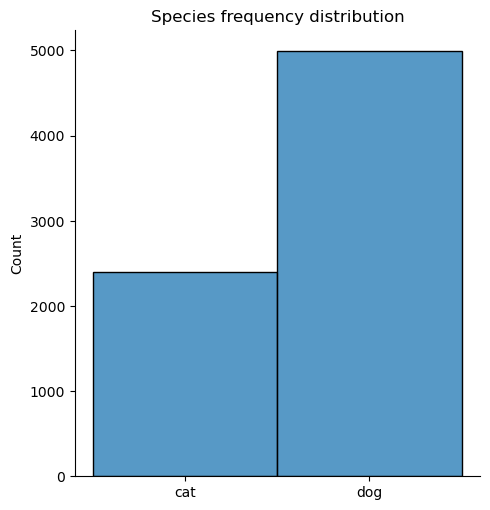

In [4]:
sns.displot(
    labels["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

There's a clear unbalance of species, as there are _almost_ twice the amount of dogs than cats. In this case, we have a couple of options:

-   **Donwsample** the dog values to meet the current amount of cats, resulting on the removal of almost a third of our data; possibly dimishing the overal precision of dog predictions
-   **Upsample** the cat values, duplicating the current ones to match the amout of dog values; possibly creating overfitting

In this specific case, we'll be adding artificial cat data by aplying random transformations; reducing the possibility of overfitting

We can also take a look at the breed distribution as such:


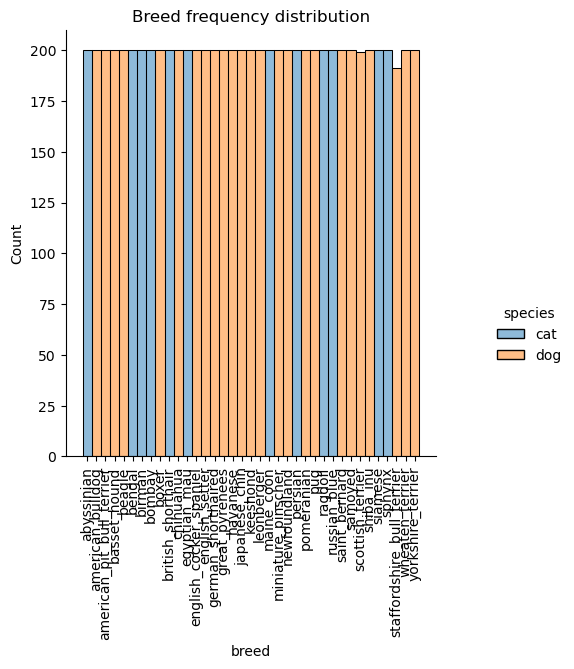

In [5]:
sns.displot(data=labels, x="breed", hue="species")
plt.title("Breed frequency distribution")
plt.xticks(rotation=90)
plt.show()

Regarding the breed, the data presents an almost perfect balanced distribution, besides `stanffordshire_bull_terrier` and `scotish_terrier`, so no modification of the available data is needed


## Cat VS Dogs Classification

### Data Augmentation

First, we'll generate new cat samples as stated above to balance out the classes. For it, a random transofmation pipeline will be created that aplies a randomized set of transformation with the objective of making the most unbiased and different images even when the same sample is selected. Then, random cat samples will be taken until the classes are balanced.


In [6]:
manipulations = [
    lambda img: rotate(img, random.randint(0, 360), mode="wrap"),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="s&p", amount=0.1),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="gaussian", var=0.01),
    lambda img: img[::-1, ::-1],
    lambda img: filters.gaussian(img, sigma=1),
]

PROPORTIONAL_MANIPULATION_AMOUNT = 2

cat_data = labels[labels["species"] == "cat"]["image_name"].to_list()

amount_of_cats = abs(sub(*labels["species"].value_counts().values))

records = []

for i in range(amount_of_cats):
    random_manipulations = random.sample(
        manipulations,
        random.randint(1, len(manipulations) // PROPORTIONAL_MANIPULATION_AMOUNT),
    )

    choice = random.choice(cat_data)
    img = reduce(
        lambda img, manipulation: manipulation(img),
        random_manipulations,
        imread(choice),
    )

    try:
        imsave(
            path.join(path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"),
            img_as_ubyte(img),
        )
    except:
        print("Had some error with image", choice, "skiping...")
        continue

    records.append(
        {
            "image_name": path.join(
                path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"
            ),
            "species": "cat",
            "breed": "_".join(path.basename(choice).split("_")[:-1]).lower(),
        }
    )

labels_cat_dogs = pd.concat([labels, pd.DataFrame(records)])

Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Abyssinian_5.jpg skiping...
Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Egyptian_Mau_186.jpg skiping...
Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Abyssinian_5.jpg skiping...


Checking the frequency of cats and dogs should result in both having roughly the same amount of observations:


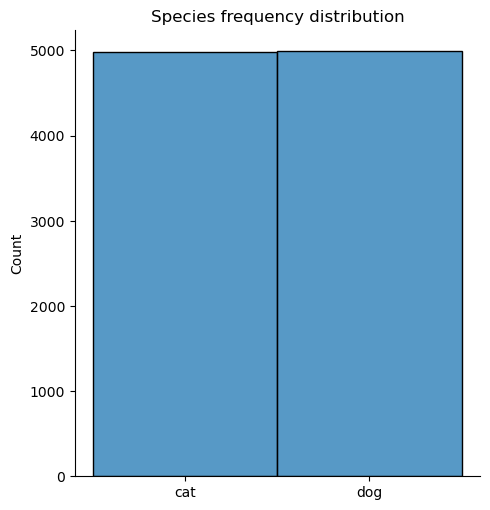

In [7]:
sns.displot(
    labels_cat_dogs["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

Having a balanced dataset resolves a problem where the model is more inclined to predict an image as the class that has more observations. For example, in an extreme case, if we had 1 cat and 99 dogs, the model will label every image as a dog, as it has a 99% chance to get it right.

### Normalization Mean and Standard Deviation

Before we load the images, the calculation of the mean and standard deviation of the images recomended to define custom values for the normalization process under the transformation of each image


In [8]:
def calculate_mean_std(paths: list[str]) -> tuple[int, int]:
    mean = np.zeros(3)
    std = np.zeros(3)

    for path in paths:
        try:
            img = imread(path)
            img = img_as_float(img)
            if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
                img = color.gray2rgb(img)
            img = img.transpose((2, 0, 1))
            img = img.reshape(3, -1)
            mean += img.mean(axis=1)
            std += img.std(axis=1)
        except:
            print("failure on image", path, " skiping...")
            continue

    mean /= len(paths)
    std /= len(paths)

    return mean.tolist(), std.tolist()


norm_data = calculate_mean_std(labels_cat_dogs["image_name"])

The results resemble the ones used in ImageNet:

- mean: [0.485, 0.456, 0.406]
- std: [0.229, 0.224, 0.225]

Reassuring us that these values exist within close bound of previous research. With the mean and standard deviation, a dataloader can be used to traverse the dataset.

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(CONFIG.get("IMAGE_SIZE")),
        transforms.ToTensor(),
        transforms.Normalize(*norm_data),
    ]
)

### Encoded Labels

In [15]:
encoder = LabelEncoder()
labels_cat_dogs["species"] = encoder.fit_transform(labels_cat_dogs["species"])

{0, 1}

### Train, Validation and Test Split

We'll employ the 70/15/15 as some recomendations found [here](https://www.v7labs.com/blog/train-validation-test-set). In this case, a custom implementation of the [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) util from Pytorch has been crafted.

In [16]:
rest_data, train_data, rest_pred, train_pred = train_test_split(
    labels_cat_dogs["image_name"],
    labels_cat_dogs["species"],
    test_size=0.7,
    random_state=CONFIG.get("SEED"),
)

val_data, test_data, val_pred, test_pred = train_test_split(
    rest_data, rest_pred, test_size=0.5, random_state=CONFIG.get("SEED")
)

train_dl = DataLoader(CatDogDataset(train_data, train_pred, transform), batch_size=100)
val_dl = DataLoader(CatDogDataset(val_data, val_pred, transform), batch_size=100)
test_dl = DataLoader(CatDogDataset(test_data, test_pred, transform), batch_size=100)

### Model specification

The main structure is the following.

- Two big layers of `2D convolution`, `maxpool` to reduce the dimensions and `ReLU`
- An early `Dropout`
- A set of `Linear` and `Dropout` layers
- As we want a binary output, a linear final layer of two outputs